### Gregory Croisdale
#### Number Theory HW3
#### 9/12/2020

In [1]:
# this is a quite extensive abstract group class.
# feel free to look at it if you want, but I have
# made many attempts at optimization that unfortunately
# leave the code in a state which is very difficult to parse.
# I would be more than happy to answer any questions or explain
# portions if you so desire :)

from itertools import permutations
from copy import deepcopy

def testBjct(bjct, a, b):
    for j in a:
        for k in a:
            # translate to other's elements
            t_j, t_k = bjct[j], bjct[k]
            # check if bijection gives the right value
            if bjct[a[j][k]] != b[t_j][t_k]:
                return False
    return True

class Group:
    def __init__(self, elm, data = {}, op = print, verbose=True):
        # this dictionary stores all elements of the group table
        self.data    = {}
        # stores the order of each element and a list which holds generators (also elements keyed on order)
        self.orders  = {}
        self.ord_elm = {}
        self.gens    = []
        # a set which contains the elements
        self.elm     = set(elm)
        # the identity element
        self.id      = None
        # boolean which indicates abelian and/or cyclic
        self.abelian = None
        self.cyclic  = None
        # save verbosity setting
        self.verbose = verbose
        
        # Verify we have some input to go off of
        if len(data) != len(elm):
            if op == print:
                raise Exception("Neither data nor func are well-defined")
            # function was passed in
            else:
                # make table from func
                for i in elm:
                    self.data[i] = {}
                    for j in elm: 
                        self.data[i][j] = op(i, j)
        else:
            # data was passed in
            # check that we have appropriate parameters
            for i in elm:
                # check that key exists
                if i not in data:
                    raise Exception("missing key " + str(i))
                # check that subkey exists
                for j in data:
                    if i not in data[j]:
                        raise Exception("missing key " + str(j) + " from " + str(i))
            # we're good to go! save data
            self.data = data
        
        # verify that this is actually a group
        if not self.verify(verbose=self.verbose):
            print("Warning! Not a group! Further behavior may be undefined.")
    
    def __repr__(self):
        # sort our elements to be fancy (and stable)
        elm = sorted(list(self.elm))
        
        # find width size
        width = max([len(str(i)) for i in elm]) + 1
        out = " " * width + " |"
        
        # first row labels
        for i in elm:
            out += "{0:>{2}}{1:>2}".format(str(i), "|", width)
        out += " Order"
        row_width = len(out) + 1
        out += "\n" + "-" * row_width
        
        for i in elm:
            # print row header
            out += "\n{0:>{2}} {1:}".format(str(i), "|", width)
            # print elements
            for j in elm:
                out += "{0:>{2}}{1:>2}".format(str(self.data[i][j]), "|", width)
            out += " {}".format(self.orders[i])
            out += "\n" + "-" * row_width
        return out
    
    def __eq__(self, other):
        # do some basic checks
        # check if both groups have same n elements
        if (len(self.elm) != len(other.elm)):
            return False
        # check if group has some n of elements of i order
        for i in self.ord_elm:
            if len(self.ord_elm[i]) != len(other.ord_elm[i]):
                return False
        
        # generate possible bijections
        p_bjct = [{}]
        # for each unqiue order
        for i in self.ord_elm:
            # make a new list to store new bijections
            new_bjct = []
            # for every possible combination of elements with this order
            for j in permutations(self.ord_elm[i]):
                # for every existing bijection
                for k in p_bjct:
                    # make a copy of the bijection
                    bjct = deepcopy(k)
                    # and add the new mapping to this bijection
                    for h in range(len(j)):
                        bjct[j[h]] = other.ord_elm[i][h]
                    # add bijection to running list
                    new_bjct += [bjct]
            # replace possible bijections with newly updated bijections
            p_bjct = new_bjct
        
        # test the bijections we generated
        for i in p_bjct:
            if testBjct(i, self.data, other.data):
                print(i)
                return True
            
        return False
    
    def __ne__(self, other):
        return not self.__eq__(other)
    
    def verify(self, verbose=True):
        # default group values
        self.cyclic  = False
        self.abelian = True
        self.gens    = []
        
        # find identity element, check closure, verify associativity
        for i in self.elm:
            # determine if elegible for id elmnt
            id_cand = False
            if self.data[i][i] == i:
                id_cand = True
            
            for j in self.elm:
                # if id check, make sure that id is returned
                # otherwise, just check closure
                if id_cand:
                    if self.data[i][j] != j:
                        if verbose:
                            print(str(i) + " + " + str(j) + " != " + str(j))
                        return False
                else:
                    if self.data[i][j] not in self.elm:
                        print(str(self.data[i][j]) + " is not in " + str(self.elm))
                        return False
                
                # verify associativity
                # h + (i + j) = (h + i) + j
                for h in self.elm:
                    if self.data[h][self.data[i][j]] != self.data[self.data[h][i]][j]:
                        if verbose:
                            print(str(h) + " + (" + str(i) + " + " + str(j) + ")"
                             + " != " + " (" + str(h) + " + " + str(i) + ")")
                        return False
                
                # Just for fun, let's also verify commutativity
                if self.data[i][j] != self.data[j][i]:
                    self.abelian = False
                
            # check id
            if id_cand:
                if verbose: print("id element found: " + str(i))
                self.id = i
                id_cand = False
                
        if verbose:
            print("Associative           ✓")
            print("Closed under operator ✓")

        # check that an ID element was found
        if self.id == None:
            if verbose: print("No identity element found!")
            return False
        else:
            if verbose: print("Identity element      ✓")

        
        # Check for inversions and find order
        for i in self.elm:
            found = False
            for j in self.elm:
                if self.data[i][j] == self.id:
                    found = True
            if not found:
                if verbose: print(str(i) + " has no inversion!")
                return False
            # this is the element which we are operating on
            _i = i
            order = 1
            # keep operating until we get id
            while _i != self.id:
                _i = self.data[i][_i]
                order += 1
                if order > len(self.elm):
                    order = float("inf")
                    break
            # add to dictionary and detect generators
            self.orders[i]      = order
            if (order not in self.ord_elm):
                self.ord_elm[order] = []
            self.ord_elm[order] += [i]
            
            if order == len(self.elm):
                self.gens  += [i]
                self.cyclic = True
        
        # We've checked everything!
        if verbose:
            print("Inversions exist      ✓")
            print("Is group              ✓")
            if self.abelian:
                print("Abelian               ✓")
            else:
                print("Abelian               ✘")
            if self.cyclic:
                print("Cyclic                ✓")
            else:
                print("Cyclic                ✘")
                
        return True

# Testing code:
_ = """#def tup(a, b):
#    return (a[0]*b[0],a[1]*b[1])

#b = Group([(1,1),(1,-1),(-1,1),(-1,-1)], op=tup)
#print(b)
#print("=" * 30)
def mod5(a, b):
    return (a * b) % 5
def mod10(a, b):
    return (a * b) % 10
#def mod229(a, b):
#    return (a * b) % 229
#from time import time
#before = time()
a = Group([*range(1,5)], op=mod5)
print(a)

b = Group([1,3,7,9], op=mod10)
print(b)

assert a == b
#print(time() - before)
#print()

#prime_list = [2] + [*filter(lambda i:all(i%j for j in range(3,i,2)), range(3,10000,2))] 
#print(prime_list)"""

## 2.10

#### 2) Let $G$ have as elements the four pairs $(1,1),(1,-1),(-1,1),(-1,-1)$, and let $(a,b)\oplus(c,d)=(ac,bd)$. Prove that $G$ is a group.

In [2]:
def g1_op(a, b):
    return (a[0] * b[0], a[1] * b[1])

print("Creating and verifying g_1:")
g_1 = Group([(1,1),(1,-1),(-1,1),(-1,-1)], op=g1_op)
print(g_1)

Creating and verifying g_1:
id element found: (1, 1)
Associative           ✓
Closed under operator ✓
Identity element      ✓
Inversions exist      ✓
Is group              ✓
Abelian               ✓
Cyclic                ✘
          | (-1, -1) |  (-1, 1) |  (1, -1) |   (1, 1) | Order
--------------------------------------------------------------
 (-1, -1) |   (1, 1) |  (1, -1) |  (-1, 1) | (-1, -1) | 2
--------------------------------------------------------------
  (-1, 1) |  (1, -1) |   (1, 1) | (-1, -1) |  (-1, 1) | 2
--------------------------------------------------------------
  (1, -1) |  (-1, 1) | (-1, -1) |   (1, 1) |  (1, -1) | 2
--------------------------------------------------------------
   (1, 1) | (-1, -1) |  (-1, 1) |  (1, -1) |   (1, 1) | 1
--------------------------------------------------------------


#### 4) Prove that the set of elements $e, a, b, c$ with the following table for the binary operation is a group. Prove that this group is isomorphic to the additive group modulo 4.

In [3]:
print("g_2: Information for group with elements e, a, b, c")
g_2 = Group(["e", "a", "b", "c"], {
    "e": {"e": "e", "a": "a", "b": "b", "c": "c"},
    "a": {"e": "a", "a": "e", "b": "c", "c": "b"},
    "b": {"e": "b", "a": "c", "b": "a", "c": "e"},
    "c": {"e": "c", "a": "b", "b": "e", "c": "a"}
})
print(g_2)

print("\ng_3: Information for additive group under mod 4")
def add4(a, b):
    return (a + b) % 4

g_3 = Group([0, 1, 2, 3], op=add4)
print(g_3)

print("\nAttempting to find bijection between two groups...")
if g_2 == g_3:
    print("Bijection found! Groups are isomorphic. ✓")
else:
    print("Math machine broke.")

g_2: Information for group with elements e, a, b, c
id element found: e
Associative           ✓
Closed under operator ✓
Identity element      ✓
Inversions exist      ✓
Is group              ✓
Abelian               ✓
Cyclic                ✓
   | a | b | c | e | Order
---------------------------
 a | e | c | b | a | 2
---------------------------
 b | c | a | e | b | 4
---------------------------
 c | b | e | a | c | 4
---------------------------
 e | a | b | c | e | 1
---------------------------

g_3: Information for additive group under mod 4
id element found: 0
Associative           ✓
Closed under operator ✓
Identity element      ✓
Inversions exist      ✓
Is group              ✓
Abelian               ✓
Cyclic                ✓
   | 0 | 1 | 2 | 3 | Order
---------------------------
 0 | 0 | 1 | 2 | 3 | 1
---------------------------
 1 | 1 | 2 | 3 | 0 | 4
---------------------------
 2 | 2 | 3 | 0 | 1 | 2
---------------------------
 3 | 3 | 0 | 1 | 2 | 4
---------------------------

Atte

#### 5) Prove that the set of elements $e, u, v, w,$ with the following table for the binary operation is a group. Prove that this group is not isomorphic to the additive group modulo 4, but that it is isomorphic to the group described in Problem 2.

In [4]:
print("Creating and verifying Group g_4:")
g_4 = Group(["e", "u", "v", "w"], {
    "e": {"e": "e", "u": "u", "v": "v", "w": "w"},
    "u": {"e": "u", "u": "e", "v": "w", "w": "v"},
    "v": {"e": "v", "u": "w", "v": "e", "w": "u"},
    "w": {"e": "w", "u": "v", "v": "u", "w": "e"}
})
print(str(g_4))

print("\n")

if g_4 == g_3:
    print("Math machine broke")
else:
    print("Additive group mod 4 not isomorphic to g_4.\n")
    
if g_4 == g_1:
    print("g_4 is isomorphic to g_1 ✓")
else:
    print("Math machine broke")

Creating and verifying Group g_4:
id element found: e
Associative           ✓
Closed under operator ✓
Identity element      ✓
Inversions exist      ✓
Is group              ✓
Abelian               ✓
Cyclic                ✘
   | e | u | v | w | Order
---------------------------
 e | e | u | v | w | 1
---------------------------
 u | u | e | w | v | 2
---------------------------
 v | v | w | e | u | 2
---------------------------
 w | w | v | u | e | 2
---------------------------


Additive group mod 4 not isomorphic to g_4.

{'e': (1, 1), 'w': (-1, 1), 'v': (-1, -1), 'u': (1, -1)}
g_4 is isomorphic to g_1 ✓


#### 6) Prove that the set of elements 1, 2, 3, 4, under the operation of multiplication modulo 5, is a group that is isomorphic to the group in Problem 4. 

In [5]:
def mod5(a, b):
    return (a * b) % 5

print("Creating and verifying Group g_5 under mod 5")
g_5 = Group([1,2,3,4], op=mod5)
print(g_5)

print("\nChecking if isomorphic to g_3")
if (g_3 == g_5):
    print("Bijection found!")
else:
    print("Math machine broke")

Creating and verifying Group g_5 under mod 5
id element found: 1
Associative           ✓
Closed under operator ✓
Identity element      ✓
Inversions exist      ✓
Is group              ✓
Abelian               ✓
Cyclic                ✓
   | 1 | 2 | 3 | 4 | Order
---------------------------
 1 | 1 | 2 | 3 | 4 | 1
---------------------------
 2 | 2 | 4 | 1 | 3 | 4
---------------------------
 3 | 3 | 1 | 4 | 2 | 4
---------------------------
 4 | 4 | 3 | 2 | 1 | 2
---------------------------

Checking if isomorphic to g_3
{0: 1, 1: 2, 3: 3, 2: 4}
Bijection found!


## 2.1

#### 23) Prove that $n^{13} - n$ is divisble by $2,3,5,7$ and $13$ for any integer $n$.



By Fermat's Little Theorem, $13|n^{13} - n$.<br>
Similarly, $7|(n^7-n)(n^6+1)$.<br>
Similarly, $5|(n^5-n)(n^8+n^4+1)$.<br>
Similarly, $3|(n^3-n)(n^{10} + n^8 + n^6 + n^4 + n^2 + 1)$.<br>
Similarly, $2|(n^2-n)(n^{11} + n^{10} + n^9 + n^8 + n^7 + n^6 + n^5 + n^4 + n^3 + n^2 + n + 1)$.

## Time for some fun:

In [6]:
# You asked for the biggest group my code can handle - here goes nothing!

import numpy as np
from time import time

# generate primes using wilson's theorem
primes = [2] + [i for i in range(3,10000,2) if np.math.factorial(i - 1) % i == (i - 1)]
primes.reverse()

runtime = []

print("Found groups:")

# keep generating groups from the primes until it takes 30 seconds
g = None
dt = 0
while (dt < 30):
    start = time()
    p = primes.pop()
    print("{:<4} in ?".format(p), end="")
    g = Group([*range(1, p)], op=lambda a, b : a * b % p, verbose=False)
    dt = time() - start
    res = {"n": p, "time": dt, "generators": g.gens}
    runtime += [res]
    print("\b{:.5f}s".format(dt))

# just for fun, let's look at the generators of the final group.
print("\nGenerators of " + str(p) + ": " + str(g.gens))

Found groups:
2    in 0.00004s
3    in 0.00002s
5    in 0.00004s
7    in 0.00007s
11   in 0.00026s
13   in 0.00040s
17   in 0.00093s
19   in 0.00123s
23   in 0.00209s
29   in 0.00432s
31   in 0.00538s
37   in 0.00897s
41   in 0.01244s
43   in 0.01436s
47   in 0.01893s
53   in 0.02699s
59   in 0.03737s
61   in 0.04161s
67   in 0.05483s
71   in 0.06557s
73   in 0.07127s
79   in 0.09131s
83   in 0.10567s
89   in 0.13059s
97   in 0.16870s
101  in 0.19168s
103  in 0.20316s
107  in 0.22407s
109  in 0.23679s
113  in 0.26587s
127  in 0.37563s
131  in 0.41178s
137  in 0.47374s
139  in 0.49408s
149  in 0.60692s
151  in 0.63532s
157  in 0.71201s
163  in 0.80103s
167  in 0.87553s
173  in 0.98480s
179  in 1.07117s
181  in 1.11323s
191  in 1.29508s
193  in 1.35615s
197  in 1.43889s
199  in 1.49604s
211  in 1.77147s
223  in 2.09695s
227  in 2.21229s
229  in 2.32750s
233  in 2.40983s
239  in 2.59987s
241  in 2.66989s
251  in 3.02215s
257  in 3.24678s
263  in 3.49300s
269  in 3.77076s
271  in 3.87297s


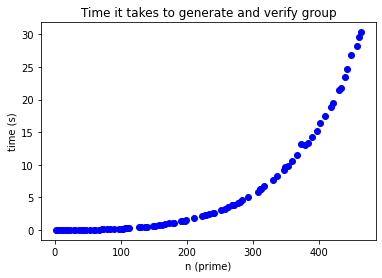

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot([i["n"] for i in runtime], [i["time"] for i in runtime], 'bo')

ax.set(xlabel='n (prime)', ylabel='time (s)',
       title='Time it takes to generate and verify group')
plt.savefig('time.png')

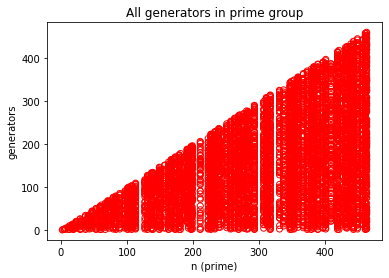

In [12]:
import matplotlib.pyplot as plt

x, y = [], []
for i in runtime:
    for j in range(len(i["generators"])):
        x += [i["n"]]
        y += [i["generators"][j]]

fig, ax = plt.subplots()
ax.scatter(x, y, facecolors='none', edgecolors='r')

ax.set(xlabel='n (prime)', ylabel='generators',
       title='All generators in prime group')
plt.savefig('all_gen.png')

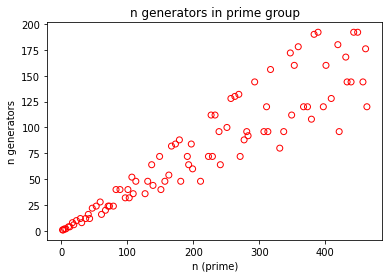

In [13]:
# Let's look at the number of generators

x, y = [], []
for i in runtime:
    x += [i["n"]]
    y += [len(i["generators"])]
        
fig, ax = plt.subplots()
ax.scatter(x, y, facecolors='none', edgecolors='r')

ax.set(xlabel='n (prime)', ylabel='n generators',
       title='n generators in prime group')
plt.savefig('n_gen.png')